## CASE STUDY - NYC Restaurant Inspection Risk Classification

**Tasks:**
  * Load & Filter: Select columns, drop entries without risk_category.
  * Text & Categorical Prep: Clean violation_code & action, encode borough & month.
  * Modeling: Predict risk_category (Low/Moderate/High) with multiclass classifier; handle imbalance.
  * Evaluation & Visualization: Report accuracy, macro-F1, confusion matrix; map high-risk by borough.
  * Takeaways: Identify violation codes predicting high risk.

**Bonus (Generative AI):**
  Prompt GPT to draft health department alerts for rising high-risk areas.

**Deliverables:**
 * Jupyter Notebook with code and analysis.
 * 5–7-slide Deck summarizing approach and results.
 * README with setup & execution instructions.

## Import Packages <a id="import-packages"></a>

In [1]:
import sys
import os
import requests


repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(repo_root, 'src')
data_path = os.path.join(repo_root, 'data')

# Add src/ to sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

# Add data/ to sys.path
if data_path not in sys.path:
    sys.path.append(data_path)

In [125]:
import warnings

import pandas as pd
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap
from IPython.display import display, HTML

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

from utils import missing_data, clean_text_generic
from llm_call import classify_violations_llm
from plots import plot_box_plot, plot_corr_heatmap, plot_paralel_bar_plot, plot_violation_code_analysis, stacked_bar_plot, pie_distribution_category
from model import plot_feature_importance, train_with_random_search
from config import MISTRAL_API_ENDPOINT, HEADERS, CSV_FILE

warnings.filterwarnings('ignore')

## 1. Load And Filter

### 1.1. Load data and initial glance to the data

In [3]:
# Load and drop duplicates
data_inspections = pd.read_csv(os.path.join(data_path, CSV_FILE)).drop_duplicates()
print(f"Initial dataset shape: {data_inspections.shape}")
data_inspections.info()

# there camis and date_inspection that have two different scores, i just the one that appears twice
data_inspections = data_inspections.drop(index=72959)

# Show missing data report
missing_data(data_inspections)

Initial dataset shape: (99996, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  99996 non-null  int64  
 1   dba                    99993 non-null  object 
 2   boro                   99996 non-null  object 
 3   building               99791 non-null  object 
 4   street                 99991 non-null  object 
 5   zipcode                98965 non-null  float64
 6   phone                  99993 non-null  object 
 7   cuisine_description    98231 non-null  object 
 8   inspection_date        99996 non-null  object 
 9   action                 98231 non-null  object 
 10  violation_code         97397 non-null  object 
 11  violation_description  97397 non-null  object 
 12  critical_flag          99996 non-null  object 
 13  score                  93971 non-null  float64
 14  grade                  4

,Total,Percent
location_point1,99995,100.000000
grade_date,54662,54.664733
grade,51870,51.872594
score,6025,6.025301
violation_code,2599,2.599130
violation_description,2599,2.599130
bin,1777,1.777089
cuisine_description,1765,1.765088
action,1765,1.765088
inspection_type,1765,1.765088


### 1.2. Define risk_category & drop entries without risk_category

Based on information available online regarding this public data mainly what is present in this sites:
 * https://data.cityofnewyork.us/Health/2019-New-York-City-Restaurant-Inspection-Results/8we4-p22f/about_data
 * https://www.nyc.gov/assets/doh/downloads/pdf/rii/restaurant-grading-faq.pdf
 * https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

Based on documentation is stated that there is discrepancies between score and grade, and also grade has a lot of missing values,
so I decided to not over complicate the use-case and delete it. And also, Score is qualitative and has just 6% of missing values from here we can create risk_Category based on documentation that says:

  * Score 0–13 → Low Risk of Inspection
  * Score 14–27 → Medium Risk of Inspection
  * Score 28+ → High Risk of Inspection

Based also in documentation Score field is a sum of values from critical and general violations.

#### Extra: Analyse dicrepancies between grade and score

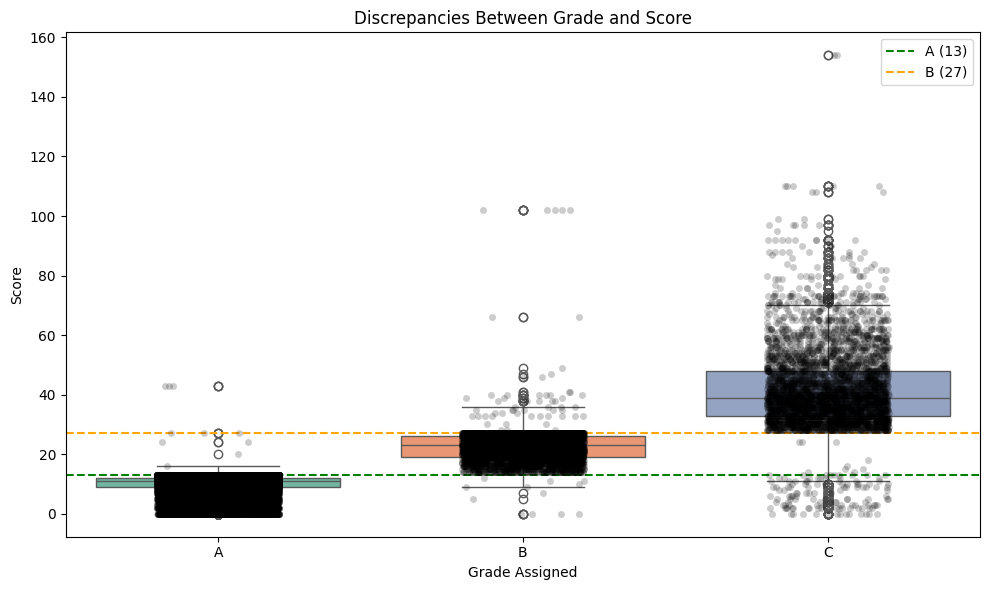

In [4]:
df_grade_score = data_inspections[data_inspections['grade'].isin(['A', 'B', 'C']) & data_inspections['score'].notnull()].copy()
plot_box_plot(df_grade_score)

#### 1.2.1 Create risk category

In [5]:
def classify_risk(score):
    if score <= 13:
        return 'Low'
    elif 14 <= score <= 27:
        return 'Moderate'
    else:
        return 'High'

print(f"Initial shape {data_inspections.shape} with this # restaurants {data_inspections.camis.nunique()}")
# lets drop grade and grade date based on initial justification
data_inspections = data_inspections.drop(columns=["grade", "grade_date"])

# drop entries without score
data_inspections = data_inspections.dropna(subset=['score'])
# create risk_category from score
data_inspections.loc[:, 'risk_category'] = data_inspections['score'].apply(classify_risk)

print(f"After initial cleaning shape {data_inspections.shape} with this # restaurants {data_inspections.camis.nunique()}")

Initial shape (99995, 27) with this # restaurants 26332
After initial cleaning shape (93970, 26) with this # restaurants 24378


### 1.3. Select columns with some EDA

The columns that are going to be deleted that seem not relevant for the use case:
* _dba_, _camis_, _phone_, _street_, _building_, _zipcode_ -> privacy information of the location and business data
*  _location_point1_ -> a lot of null values
* _score_ - because already transformed in _risk_category_ column
* _record_date_  - The date when the extract was run to produce this data set (also there is only two dates, one of then with
* Almost all locations related will be deleted 

#### Extra: EDA from some columns drop

In [6]:
data_inspections.record_date.value_counts()

record_date
2025-07-21T06:00:14.000    93916
2025-07-21T06:00:16.000       54
Name: count, dtype: int64

There are a lot of location variables overlap, probably only geographical variables and boro for geographical space.
And having a lot of sparsed dummy varibales if encoded can lead to overfit, not generalize, and over complex the model. Also due to privacy of specific locations or business.

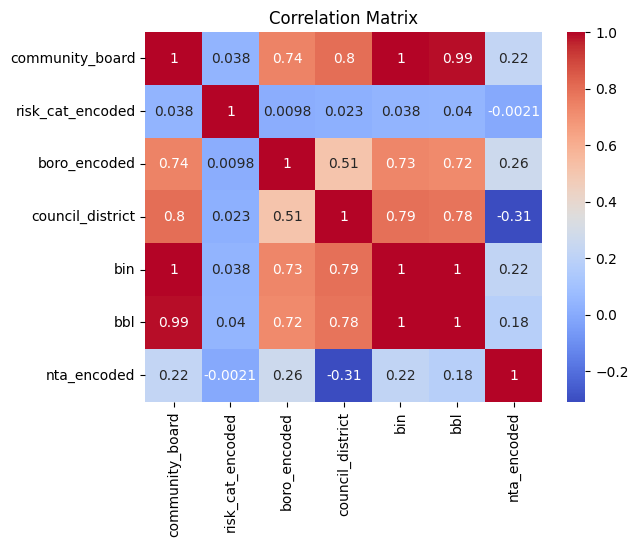

In [7]:
# Correlation matrix - boro seems enough for this problem
location_cols = ['boro', 'community_board', 'council_district', 'bin', 'bbl', 'nta']
df_location = data_inspections[location_cols + ['risk_category']]

boro_order = {'Manhattan': 0, 'Brooklyn': 1, 'Queens': 2, 'Bronx': 3, 'Staten Island': 4}
df_location['boro_encoded'] = df_location['boro'].map(boro_order)

risk_map = {'Low': 0, 'Moderate': 1, 'High': 2}
df_location['risk_cat_encoded'] = df_location['risk_category'].map(risk_map)

le_nta = LabelEncoder()
df_location['nta_encoded'] = le_nta.fit_transform(df_location['nta'].astype(str))

corr_cols = ['community_board', 'risk_cat_encoded', 'boro_encoded', 'council_district', 'bin', 'bbl', 'nta_encoded']
plot_corr_heatmap(df_location, corr_cols)


#### 1.3.1 Select columns

In [8]:
cols_to_drop = ["dba", "record_date", "location_point1", "census_tract", "phone", "score", "building", "street", "zipcode", "bin", "bbl", "street", "community_board", "council_district", "nta"]
cols_to_extra_analysis = ["latitude", "longitude"]
data_final = data_inspections.drop(columns=cols_to_drop).drop_duplicates()
data_final.info()

missing_data(data_final)

<class 'pandas.core.frame.DataFrame'>
Index: 93970 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  93970 non-null  int64  
 1   boro                   93970 non-null  object 
 2   cuisine_description    93970 non-null  object 
 3   inspection_date        93970 non-null  object 
 4   action                 93970 non-null  object 
 5   violation_code         93439 non-null  object 
 6   violation_description  93439 non-null  object 
 7   critical_flag          93970 non-null  object 
 8   inspection_type        93970 non-null  object 
 9   latitude               93845 non-null  float64
 10  longitude              93845 non-null  float64
 11  risk_category          93970 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.3+ MB


,Total,Percent
violation_code,531,0.565074
violation_description,531,0.565074
latitude,125,0.133021
longitude,125,0.133021
camis,0,0.000000
boro,0,0.000000
cuisine_description,0,0.000000
inspection_date,0,0.000000
action,0,0.000000
critical_flag,0,0.000000


## 2. Text & Categorical Prep

### 2.1.  EDA: New features need to be created?

Before transforming the dataset for modeling, it's important to understand how the score and risk_category are derived. To do this, I first examined whether multiple rows exist for the same restaurant (camis) and inspection date. These duplicates typically reflect multiple violations recorded during a single inspection. Understanding this structure is key, as the number and severity of violations likely influence the final risk_category. (I will show this later)

**Plot analysis**
I created a parallel boxplot of unique values per inspection, grouped by camis and inspection_date. The plot validated my assumption: certain columns remain constant within an inspection (e.g., inspection_type, action), while others vary (e.g., violation_code, critical_flag), reflecting multiple violations.

The end goal is to transform the dataset so that each row represents one inspection per restaurant, with engineered features and a single risk_category label.

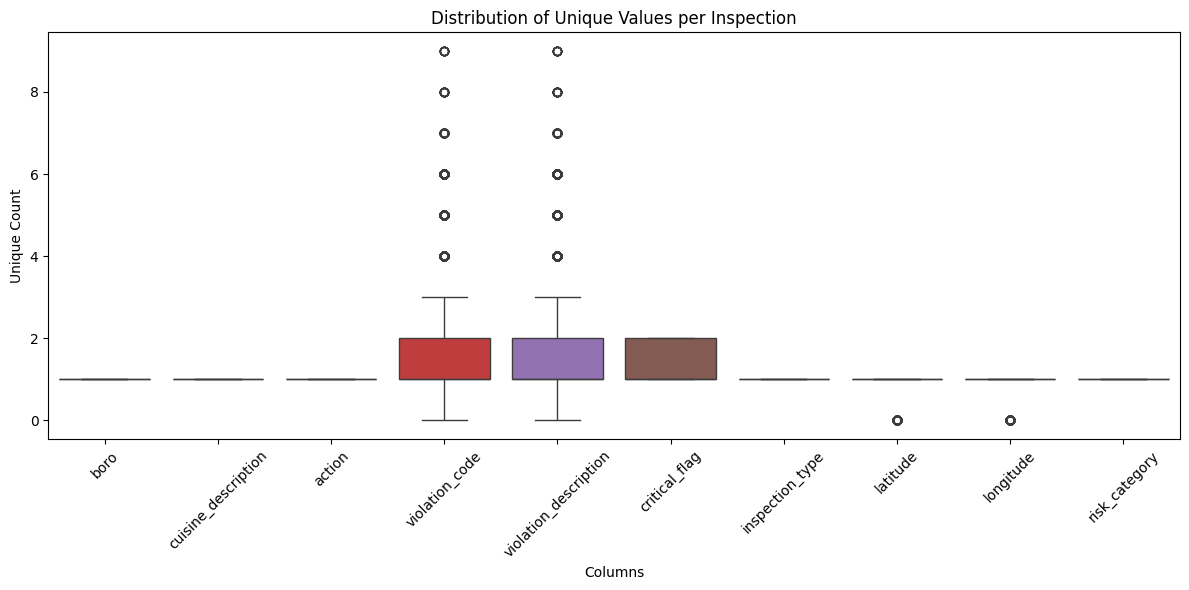

In [9]:
inspection_uniques = data_final.groupby(['camis', 'inspection_date']).nunique()
plot_paralel_bar_plot(inspection_uniques)

### 2.2. Clean features

In [10]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93970 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  93970 non-null  int64  
 1   boro                   93970 non-null  object 
 2   cuisine_description    93970 non-null  object 
 3   inspection_date        93970 non-null  object 
 4   action                 93970 non-null  object 
 5   violation_code         93439 non-null  object 
 6   violation_description  93439 non-null  object 
 7   critical_flag          93970 non-null  object 
 8   inspection_type        93970 non-null  object 
 9   latitude               93845 non-null  float64
 10  longitude              93845 non-null  float64
 11  risk_category          93970 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 9.3+ MB


##### 2.2.1 **Clean violation_code**

In [11]:
#  I want to understand if critical and violation code were 1-to-1 and they are actually are.
analysis_violation_code = data_final.groupby(['violation_code']).critical_flag.nunique().reset_index()
analysis_violation_code.critical_flag.value_counts()

# there is a violation_code with two flags. Lets fix it based on documentation https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf and distribution -> to be Not Critical instead of Not Critical
clean_violation_code = data_final[data_final.violation_code == "09A"]
clean_violation_code.critical_flag.value_counts()

clean_violation_code[clean_violation_code.critical_flag == "Critical"].violation_description.unique()# "09A"

# check that for the same violation description there is two critical flags
# value_ = 'Swollen, leaking, rusted or otherwise damaged canned food to be returned to distributor not segregated from intact product and clearly labeled DO NOT USE'
# clean_violation_code[clean_violation_code.violation_description.str.contains(value_)].head()

# lets clean this
data_final.loc[data_final['violation_code'] == '09A', 'critical_flag'] = 'Not Critical'

##### 2.2.2. **Clean violation_descrition**

In [12]:
print("Unique nb violation description BEFORE cleaning", data_final['violation_description'].nunique())
data_final['violation_description'] = data_final['violation_description'].apply(clean_text_generic)
print("Unique nb violation description AFTER cleaning", data_final['violation_description'].nunique())

Unique nb violation description BEFORE cleaning 139
Unique nb violation description AFTER cleaning 122


### 2.3. Transform and create new columns

##### 2.3.1. **Create inspection date**

I will extract some date features to understand if they are relevant for the final dataset.

In [13]:
data_final['inspection_date'] = pd.to_datetime(data_final['inspection_date'])
data_final['month'] = data_final['inspection_date'].dt.month

##### 2.3.2. **Create past nb inspections**
So for this use case I thought that creating a new feature with the number of past inspections because for that restaurant it can have a bigger probabily of having more inspections or if you never had one (so your first) or if you had a lot of then, having a lot can indicate that is a restaurant with a lot of problems.

I will analyse this later by comparing with the remaining features.

In [14]:
# to get nb_past_interventions
inspection_df = data_final[['camis', 'inspection_date']].drop_duplicates()
inspection_df = inspection_df.sort_values(['camis', 'inspection_date'])
inspection_df['nb_past_inspections'] = inspection_df.groupby('camis').cumcount()
# merge to the original one
data_final = data_final.merge(inspection_df, on=['camis', 'inspection_date'], how='left')

##### 2.3.3. **Create violation_category from violation_description using an LLM**
I am automatically generate a violation_category from violation_description using an Generative Model. This groups violations into high-level categories to make the data easier to analyze.

In [15]:
codes_df = (
    data_final[["violation_code", "violation_description"]]
    .dropna()
    .drop_duplicates()
    .groupby("violation_code")["violation_description"]
    .agg("; ".join)
    .reset_index()
)
violation_dict = codes_df.set_index("violation_code")["violation_description"].to_dict()

In [16]:
PROMPT = f"""
    You are classifying NYC restaurant health violation descriptions into concise categories.
    Group the following items into categories and give each category a name. Return the result as JSON.
    "{violation_dict}"
    return only json key is the category and for each category a dictionary with violation code and the respective original violation description.
    """

json_violations = classify_violations_llm(PROMPT, api_endpoint=MISTRAL_API_ENDPOINT, headers=HEADERS)

In [17]:
rows = [
    {
        "violation_category": category,
        "violation_code": code,
        "violation_description_llm": description
    }
    for category, violations in json_violations.items()
    for code, description in violations.items()
]

data_codes = pd.DataFrame(rows)
data_final = data_final.merge(data_codes[["violation_code", "violation_category"]], on="violation_code", how="left")

##### 2.3.4. **Group data and create new columns**

Here i am grouping by camis and inspection_date because of what already mentioned and creating some new features, like the _nb_critical_flags_ and the _nb_violations_.

In [18]:
data_transformed = data_final.groupby(['camis', 'inspection_date'], as_index=False).agg(
    boro=('boro', 'first'),
    cuisine_description=('cuisine_description', 'first'),
    action=("action", "first"),
    nb_violations=('violation_code', 'count'),
    nb_critical_flags=('critical_flag', lambda x: sum(x == 'Critical')),
    inspection_type=('inspection_type', 'first'),
    nb_past_inspections=('nb_past_inspections', 'first'),
    risk_category=('risk_category', 'first'),
    month=('month', 'first')
    )

In [19]:
data_transformed.head()

,camis,inspection_date,boro,cuisine_description,action,nb_violations,nb_critical_flags,inspection_type,nb_past_inspections,risk_category,month
0,30075445,2023-01-31,Bronx,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,2,2,Cycle Inspection / Initial Inspection,0,Moderate,1
1,30075445,2023-08-01,Bronx,Bakery Products/Desserts,Violations were cited in the following area(s).,1,1,Cycle Inspection / Initial Inspection,1,High,8
2,30075445,2024-11-08,Bronx,Bakery Products/Desserts,Violations were cited in the following area(s).,2,1,Cycle Inspection / Initial Inspection,2,Low,11
3,30191841,2024-11-20,Manhattan,Irish,Violations were cited in the following area(s).,2,1,Cycle Inspection / Initial Inspection,0,Moderate,11
4,40356483,2022-01-24,Brooklyn,Sandwiches,Violations were cited in the following area(s).,2,1,Cycle Inspection / Re-inspection,0,Low,1


### 2.4. Exploratory analysing features with risk_category

Before doing encoding of the categorical features, let's do an analysis with risk_category to understand if all features are important, to remove some features that can create complexity to the problem.

Also to understand the influence of features to predict high risk.

##### 2.4.1. **Analyse violation code**
The type of violation plays a key role in determining whether an inspection is classified as high risk. In the stacked bar chart, we notice that while the most common violation codes appear frequently, the codes with a dominant share of high risk inspections highlighted in red on the yaxis are also often marked as critical. This supports what’s stated in the NYC inspection guidelines: critical violations, especially certain types, carry more weight in the inspection score and are more likely to lead to a high-risk classification.

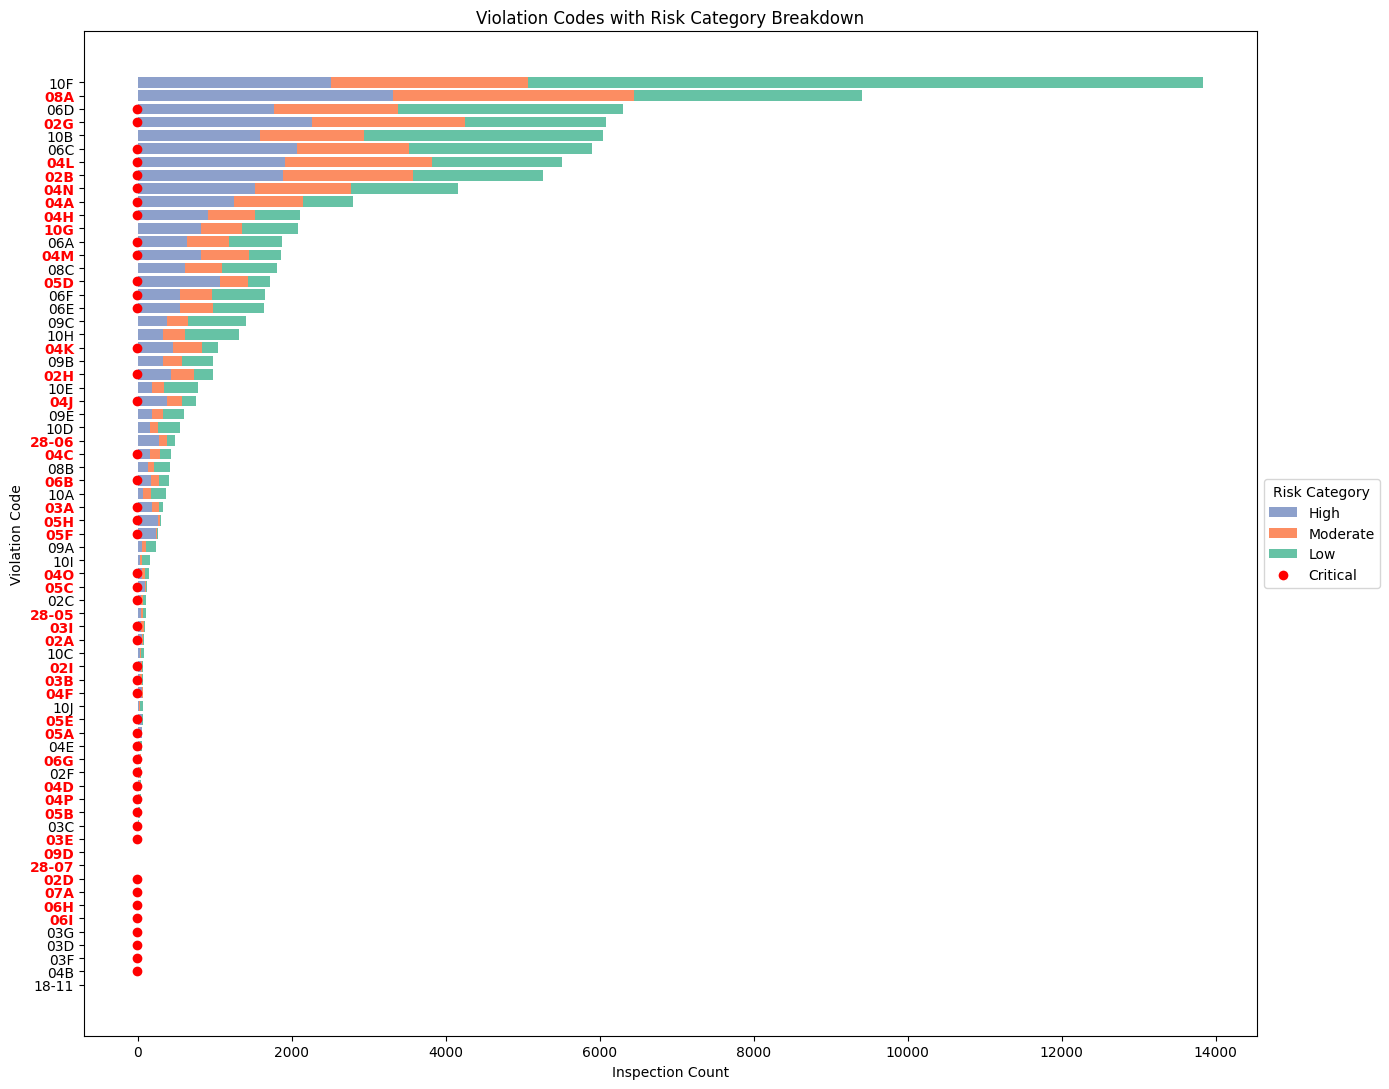

In [20]:
# plot nb of inspections per violation code, with risk category breakdown and highlighthing with red circle critical flagas and
# highlight violation code with red for the ones that high is the main category
violation_risk_dist = (
    data_final.groupby(['violation_code', 'risk_category'])
    .size()
    .unstack(fill_value=0)
)

violation_risk_dist = violation_risk_dist.loc[
    violation_risk_dist.sum(axis=1).sort_values(ascending=True).index
]

violation_critical_map = data_final.groupby('violation_code')['critical_flag'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')

plot_violation_code_analysis(violation_risk_dist, violation_critical_map)

##### 2.4.2. **Analyse critical flags, nb_violations and nb_past_inspections**

As said before, inspections with critical violations are more likely to be high risk. Also, having more violations increases the chance of being high risk. So, the number of critical violations is important for the model. Also, the past_interventions feature that I created also shows that.

In [21]:
# shows the relationship of critical flags and the number of violations can be associated with high risk

data_transformed['nb_non_critical_flags'] = data_transformed['nb_violations'] - data_transformed['nb_critical_flags']
fig = px.scatter(
    data_transformed,
    x="nb_critical_flags",
    y="nb_non_critical_flags",
    size="nb_violations",
    color="risk_category",
    hover_data=["camis"],
    labels={
        "nb_critical_flags": "Number of Critical Violations",
        "nb_non_critical_flags": "Number of Non-Critical Violations",
        "nb_violations": "Total Violations"
    },
    title="Relationship between nb of critical and non critical Violations by Risk Category"
)

fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.show()

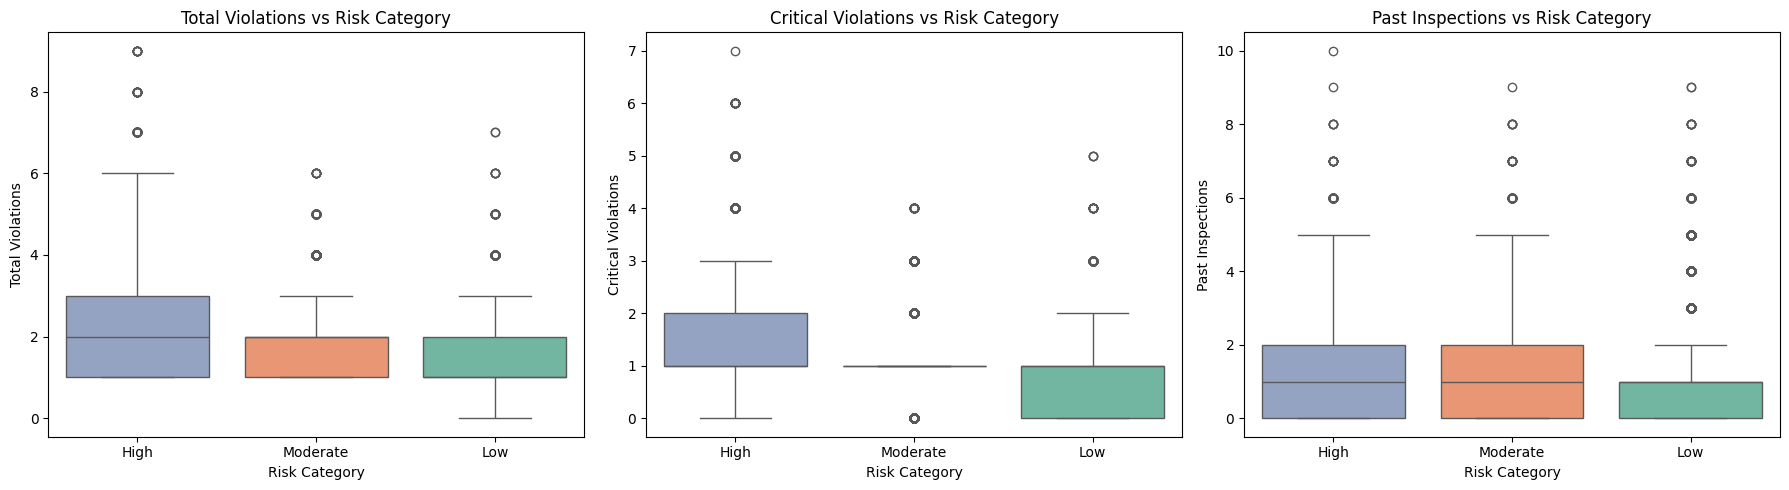

In [22]:
colors = {
    'High': '#8da0cb',
    'Moderate': '#fc8d62',
    'Low': '#66c2a5'
}

cols = ['nb_violations', 'nb_critical_flags', 'nb_past_inspections']
titles = ['Total Violations', 'Critical Violations', 'Past Inspections']

# Create boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, col in enumerate(cols):
    sns.boxplot(
        data=data_transformed,
        x='risk_category',
        y=col,
        ax=axes[i],
        order=['High', 'Moderate', 'Low'],  # Ensures color mapping is correct
        palette=colors
    )
    axes[i].set_title(f'{titles[i]} vs Risk Category')
    axes[i].set_xlabel('Risk Category')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()


##### 2.4.3. **Analyse boro**

Location shows a clear pattern in how high risk inspections are distributed. Even though Manhattan has more inspections overall, places like Queens and Brooklyn have a higher proportion of high risk cases (second bar plot). This means that even with fewer inspections, these areas tend to be riskier. So, using location in the model would definitely help improve predictions.

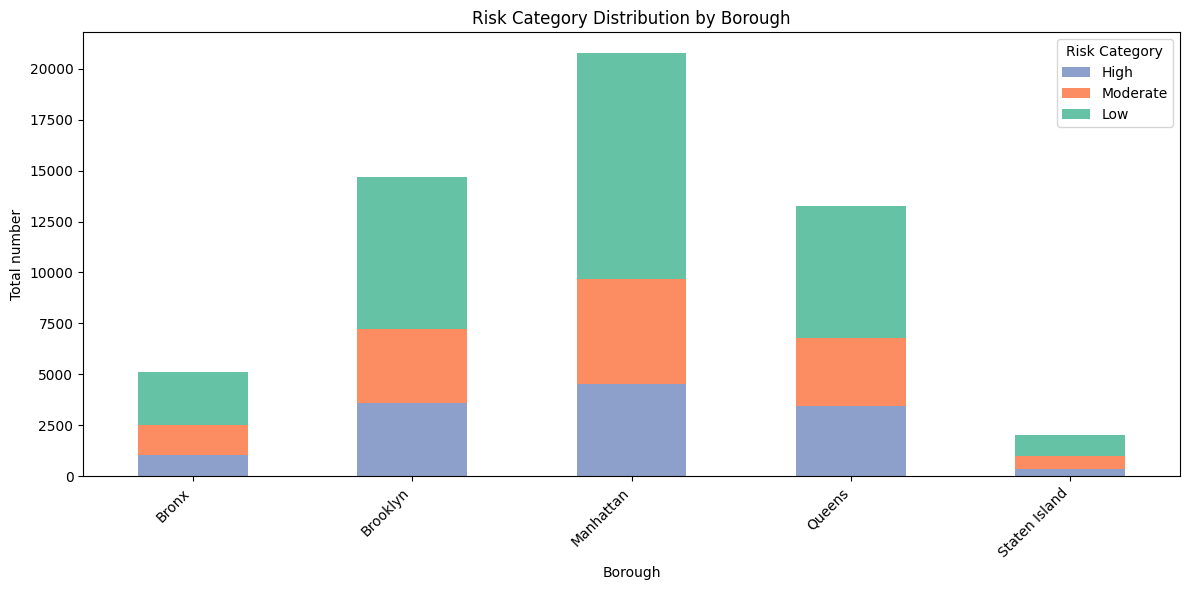

In [23]:
df_ = stacked_bar_plot(data_transformed, col_a='boro', col_b='risk_category', label_a="Borough", title="Risk Category Distribution by Borough", legend_title="Risk Category", normalize=False)

<Axes: title={'center': 'High Risk Inspections by Borough (%)'}, ylabel='boro'>

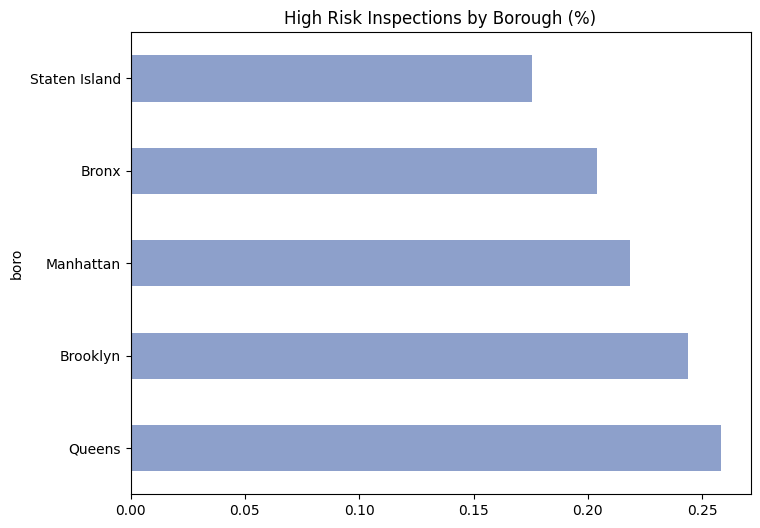

In [24]:
high_risk_counts = data_transformed[data_transformed['risk_category'] == 'High'].groupby('boro').size()
total_counts = data_transformed.groupby('boro').size()
risk_ratio = (high_risk_counts / total_counts).fillna(0).sort_values(ascending=False)

risk_ratio.plot(kind='barh', color=colors["High"], figsize=(8, 6), title='High Risk Inspections by Borough (%)')

In [119]:
risk_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
heat_data = data_inspections[data_inspections['risk_category'] == 'High'][['latitude', 'longitude']].dropna().values.tolist()
HeatMap(heat_data).add_to(risk_map)
risk_map

##### 2.4.4. **Analyse action**

Clearly action as an huge impact in risk_category associated with. So establishment CLosed are associated with high risk of inspection because there are violations such as related with Pest Control and Hygiene.

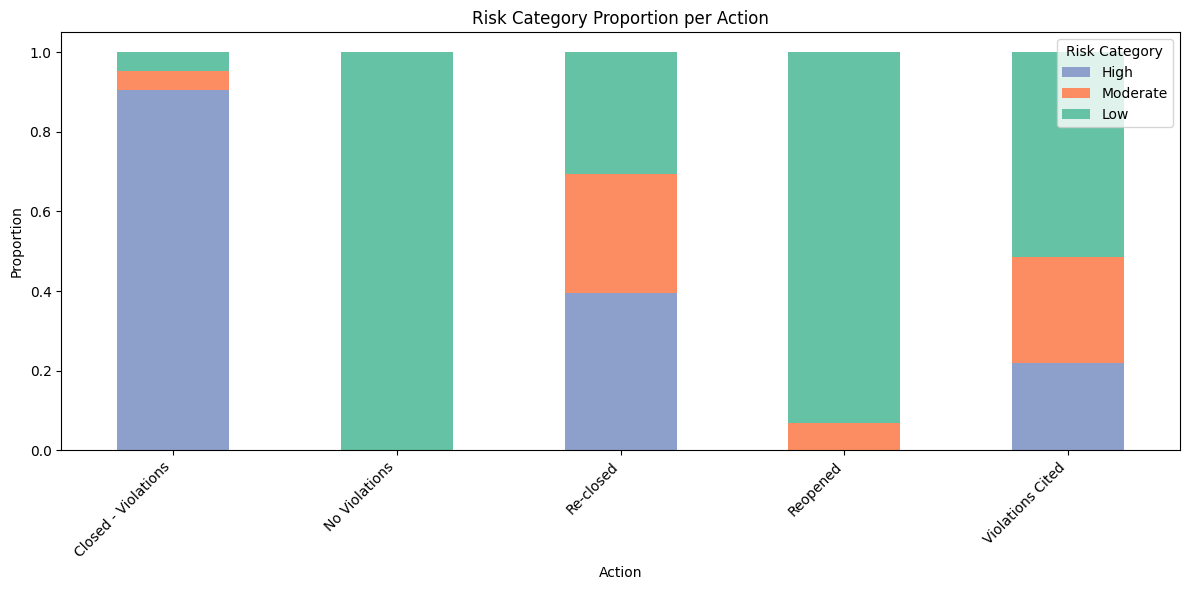

In [25]:
action_map = {
    "Violations were cited in the following area(s).": "Violations Cited",
    "Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.": "Closed - Violations",
    "Establishment re-opened by DOHMH.": "Reopened",
    "No violations were recorded at the time of this inspection.": "No Violations",
    "Establishment re-closed by DOHMH.": "Re-closed"
}

data_transformed['action_simplified'] = data_transformed['action'].map(action_map)

stacked_bar_plot(data_transformed, col_a='action_simplified', col_b='risk_category', label_a="Action", title="Risk Category Proportion per Action", legend_title="Risk Category", normalize="index")

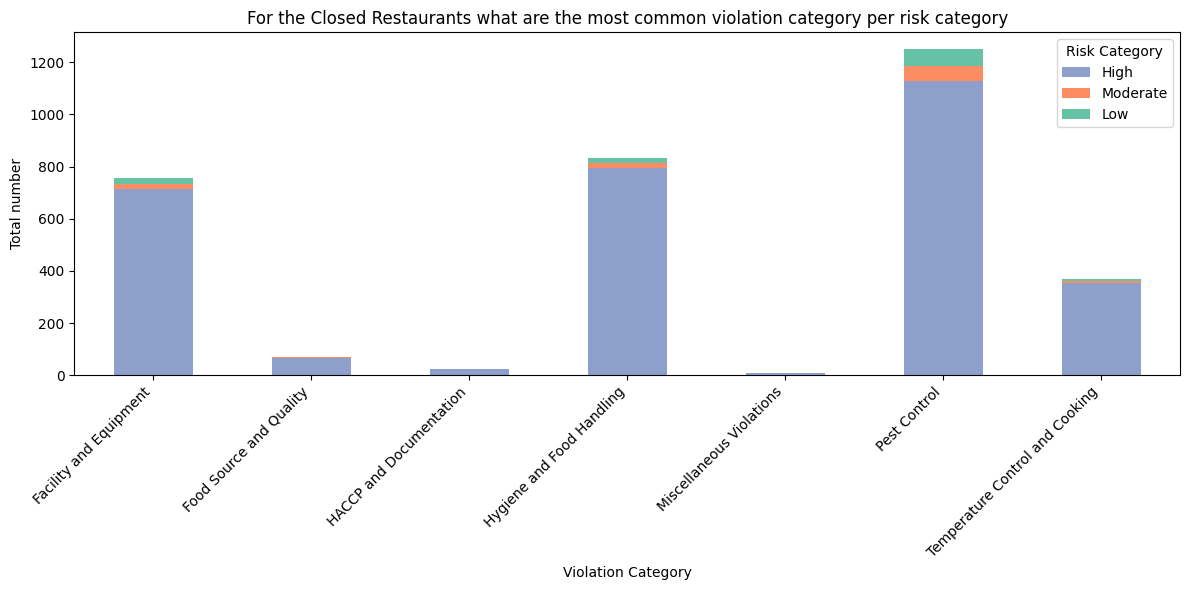

In [26]:
# Assuming 'action' column has "floor closed" or similar wording
closed_df = data_final[data_final['action'].str.contains("Establishment Closed by DOHMH.", case=True, na=False)]

# Count violation categories associated
category_counts = closed_df['violation_category'].value_counts()

stacked_bar_plot(closed_df, col_a='violation_category', col_b='risk_category', label_a="Violation Category", title="For the Closed Restaurants what are the most common violation category per risk category", legend_title="Risk Category", normalize=False)

##### 2.4.5. **Analyse cuisine description**

Cuisine type can be linked to higher inspection risks. For example, cuisines like Chinese, Caribbean, Latin American, and Spanish tend to have more inspections. Among these, Chinese cuisine has the highest number of critical violations, and it also has a predominantly high risk label.

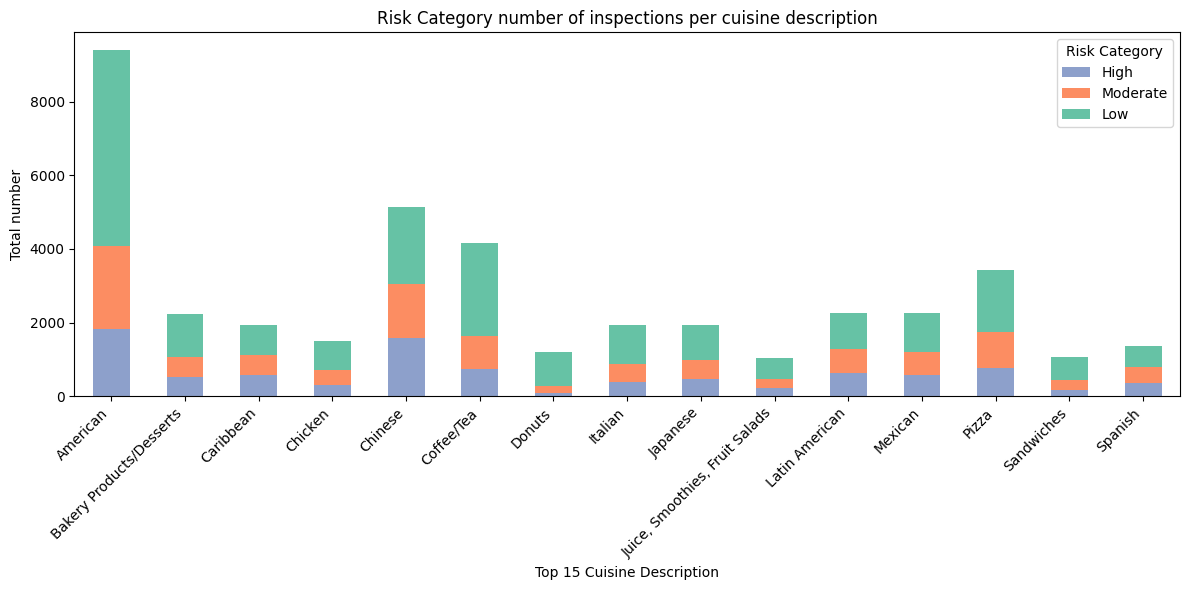

In [27]:
top_cuisines = data_transformed['cuisine_description'].value_counts().head(15).index
filtered_data = data_transformed[data_transformed['cuisine_description'].isin(top_cuisines)]

stacked_bar_plot(filtered_data, col_a='cuisine_description', col_b='risk_category', label_a="Top 15 Cuisine Description", title="Risk Category number of inspections per cuisine description", legend_title="Risk Category", normalize=False)


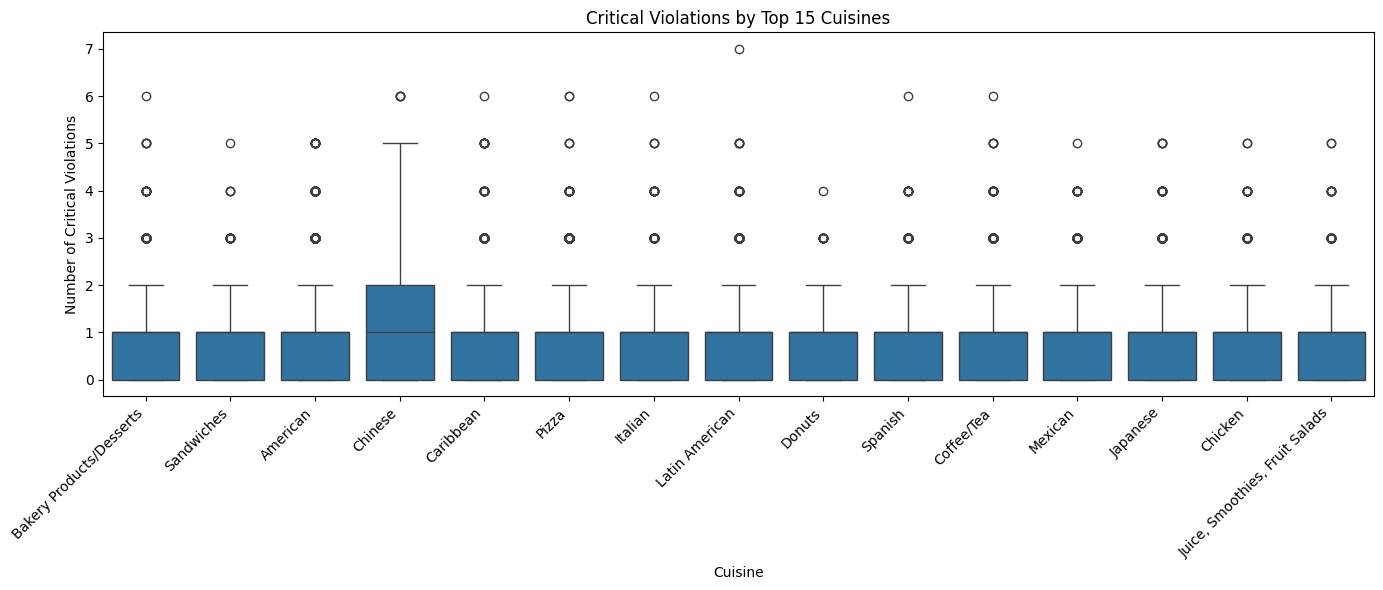

In [28]:

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_data, x='cuisine_description', y='nb_critical_flags')
plt.xticks(rotation=45, ha='right')
plt.title('Critical Violations by Top 15 Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Number of Critical Violations')
plt.tight_layout()
plt.show()


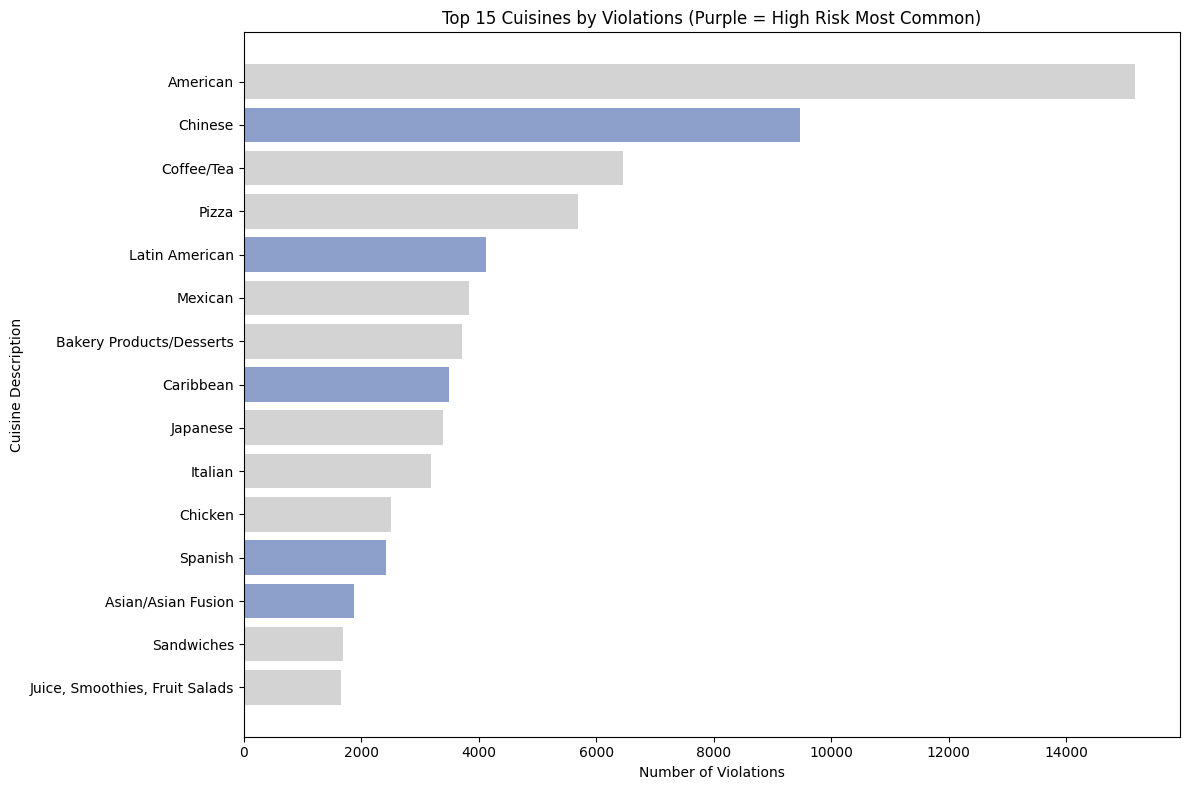

In [74]:
cuisine_risk_counts = (
    data_final.groupby(['cuisine_description', 'risk_category'])
    .size()
    .unstack(fill_value=0)
)

cuisine_risk_counts['Total'] = cuisine_risk_counts.sum(axis=1)
cuisine_risk_counts['Max_Risk'] = cuisine_risk_counts[['Low', 'Moderate', 'High']].idxmax(axis=1)

top_cuisines = cuisine_risk_counts.sort_values(by='Total', ascending=False).head(15)
highlight_cuisines = top_cuisines[top_cuisines['Max_Risk'] == 'High'].index.tolist()

plt.figure(figsize=(12,8))
bars = plt.barh(
    top_cuisines.index,
    top_cuisines['Total'],
    color=[colors["High"] if cuisine in highlight_cuisines else 'lightgrey' for cuisine in top_cuisines.index]
)

plt.xlabel('Number of Violations')
plt.ylabel('Cuisine Description')
plt.title('Top 15 Cuisines by Violations (Purple = High Risk Most Common)')
plt.gca().invert_yaxis()  # Largest on top
plt.tight_layout()
plt.show()


##### 2.4.6. **Analyse inspection_type**

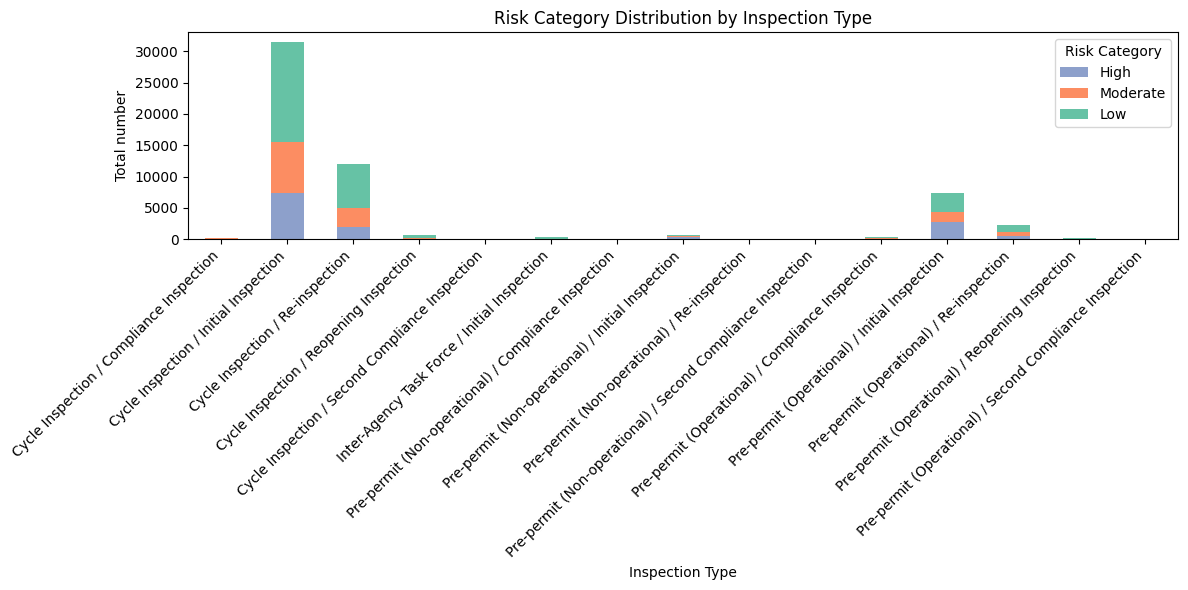

In [32]:
stacked_bar_plot(data_transformed, col_a='inspection_type', col_b='risk_category', label_a="Inspection Type", title="Risk Category Distribution by Inspection Type", legend_title="Risk Category", normalize=False)

##### 2.4.7. **Temporal features**

In [33]:
grouped = data_transformed.groupby(['month', 'risk_category']).agg(
    avg_violations=('nb_violations', 'mean'),
    count=('risk_category', 'count')
).reset_index()


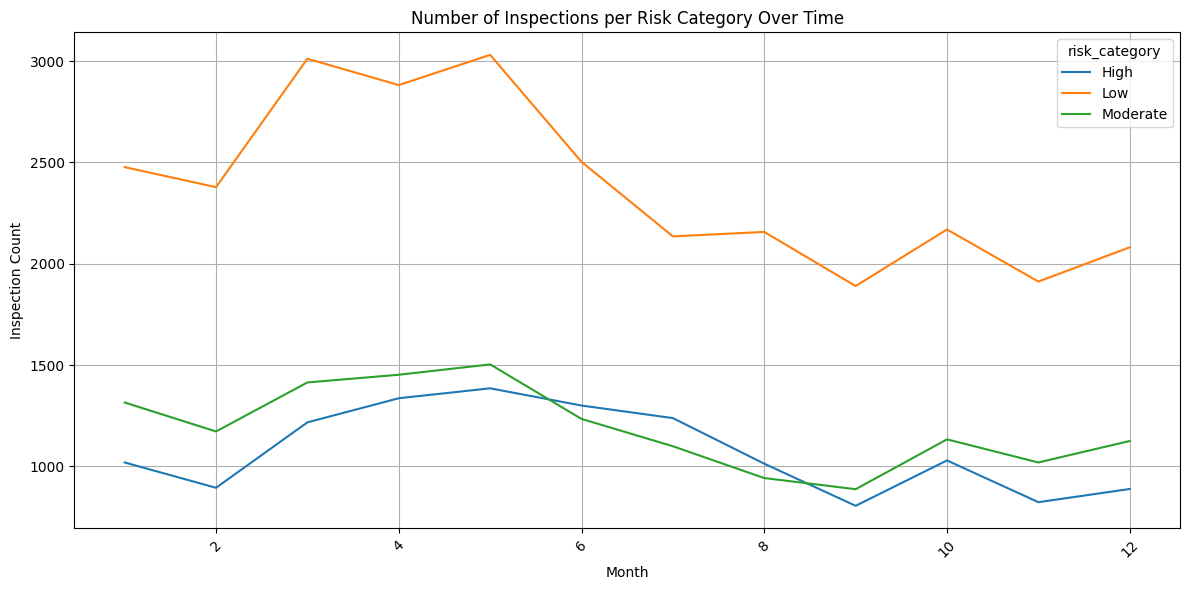

In [51]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='month', y='count', hue='risk_category')
plt.title("Number of Inspections per Risk Category Over Time")
plt.ylabel("Inspection Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

##### 2.4.8. **Violation Category features**

This category can really improve the model, to understand better what is the violation code and the category associated.

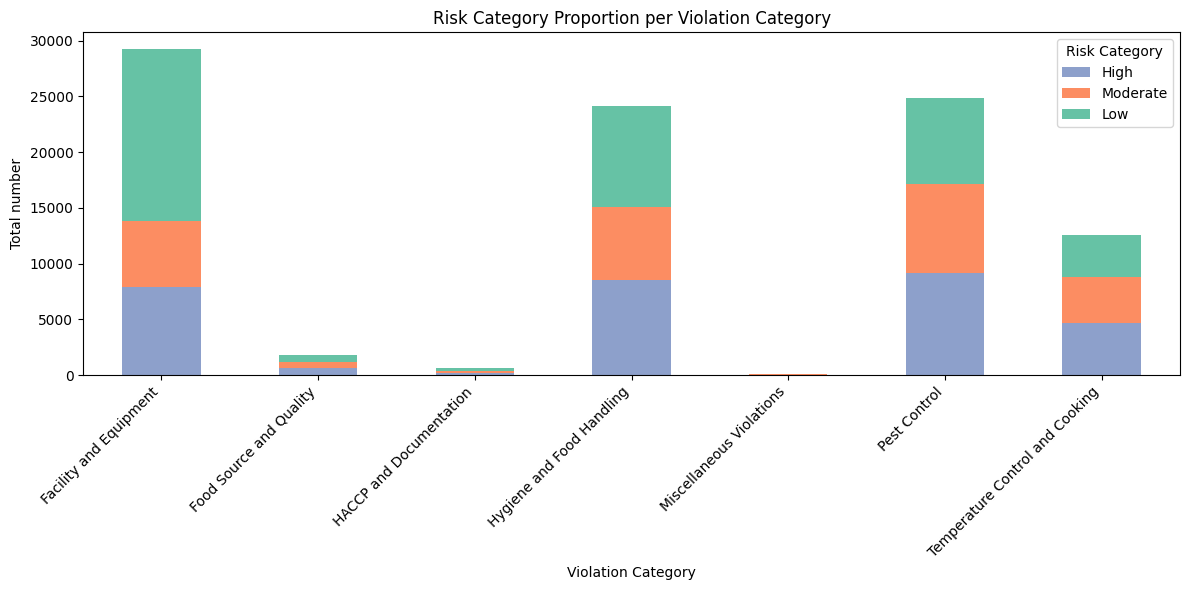

In [34]:
stacked_bar_plot(data_final, col_a='violation_category', col_b='risk_category', label_a="Violation Category", title="Risk Category Proportion per Violation Category", legend_title="Risk Category", normalize=False)

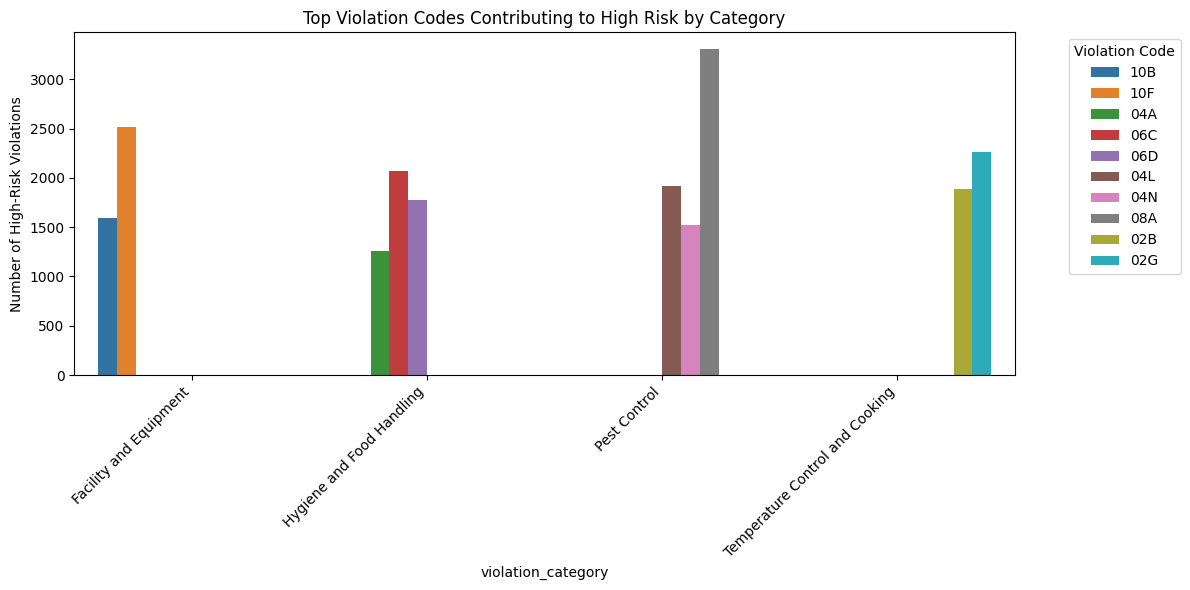

In [81]:
high_risk = data_final[data_final['risk_category'] == 'High']

violation_counts = (
    high_risk.groupby(['violation_category', 'violation_code'])
    .size()
    .reset_index(name='count')
)

top_violations = (
    violation_counts.groupby('violation_code')['count']
    .sum()
    .nlargest(10)
    .index
)
top_df = violation_counts[violation_counts['violation_code'].isin(top_violations)]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_df,
    x='violation_category',
    y='count',
    hue='violation_code'
)
plt.title('Top Violation Codes Contributing to High Risk by Category')
plt.ylabel('Number of High-Risk Violations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Violation Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 2.5. Encode Features

Based on the previous analysis, the features that for certain can be usefull would be:

* violation_code -> one hot encoding
* nb_violations
* nb_critical_flags
* action -> needs to be encoded
* inspection_type -> needs to be encoded
* violation_category

##### 2.5.1. **Encode violation code**

In [35]:
df_temp = data_final[['camis', 'inspection_date', 'violation_code']].dropna()
df_violaton_code_dummies = pd.get_dummies(df_temp['violation_code'], prefix='vc')
df_violaton_code_enc = pd.concat([df_temp[['camis', 'inspection_date']], df_violaton_code_dummies], axis=1)
df_violaton_code_enc = df_violaton_code_enc.groupby(['camis', 'inspection_date'], as_index=False).sum().fillna(0)
data_transformed = data_transformed.merge(df_violaton_code_enc, on=['camis', 'inspection_date'], how='left')

In [56]:
print(f"There are {df_violaton_code_dummies.shape[1]} violation codes")

There are 69 violation codes


##### 2.5.2. **Encode remaining columns**

In [36]:
# lets encode inspection_type
enc_insp = LabelEncoder()
data_transformed['inspection_type_enc'] = enc_insp.fit_transform(data_transformed['inspection_type'].astype(str))
data_transformed[['inspection_type_enc', "inspection_type"]].drop_duplicates()

,inspection_type_enc,inspection_type
0,1,Cycle Inspection / Initial Inspection
4,2,Cycle Inspection / Re-inspection
387,0,Cycle Inspection / Compliance Inspection
388,4,Cycle Inspection / Second Compliance Inspection
549,3,Cycle Inspection / Reopening Inspection
754,5,Inter-Agency Task Force / Initial Inspection
18990,12,Pre-permit (Operational) / Re-inspection
19860,7,Pre-permit (Non-operational) / Initial Inspection
20808,10,Pre-permit (Operational) / Compliance Inspection
20987,11,Pre-permit (Operational) / Initial Inspection


In [37]:
# lets encode action
enc_action = LabelEncoder()
data_transformed['action_enc'] = enc_action.fit_transform(data_transformed['action'].astype(str))
data_transformed[['action_enc', "action"]].drop_duplicates()

,action_enc,action
0,0,Establishment Closed by DOHMH. Violations were...
1,4,Violations were cited in the following area(s).
114,3,No violations were recorded at the time of thi...
549,1,Establishment re-closed by DOHMH.
550,2,Establishment re-opened by DOHMH.


In [38]:
# lets encode cuisine_description
enc_cuisine = LabelEncoder()
data_transformed['cuisine_encoded'] = enc_cuisine.fit_transform(data_transformed['cuisine_description'].astype(str))
data_transformed[['cuisine_encoded', "cuisine_description"]].drop_duplicates()

,cuisine_encoded,cuisine_description
0,7,Bakery Products/Desserts
3,46,Irish
4,71,Sandwiches
9,33,Frozen Desserts
10,2,American
...,...,...
23853,10,Basque
23916,60,Not Listed/Not Applicable
36666,53,Lebanese
47009,3,Armenian


In [39]:
# lets encode boro
enc_boro = LabelEncoder()
data_transformed['boro_encoded'] = enc_boro.fit_transform(data_transformed['boro'].astype(str))
data_transformed[['boro_encoded', "boro"]].drop_duplicates()

,boro_encoded,boro
0,0,Bronx
3,2,Manhattan
4,1,Brooklyn
19,3,Queens
28,4,Staten Island


In [40]:
df_temp = data_final[['camis', 'inspection_date', 'violation_category']].dropna()
df_violaton_category_dummies = pd.get_dummies(df_temp['violation_category'], prefix='vc')
df_violaton_category_enc = pd.concat([df_temp[['camis', 'inspection_date']], df_violaton_category_dummies], axis=1)
df_violaton_category_enc = df_violaton_category_enc.groupby(['camis', 'inspection_date'], as_index=False).sum().fillna(0)
data_transformed = data_transformed.merge(df_violaton_category_enc, on=['camis', 'inspection_date'], how='left').fillna(0)

In [55]:
print(f"There are {df_violaton_category_dummies.shape[1]} violation categories")

There are 7 violation categories


In [41]:
risk_enc = LabelEncoder()
data_transformed['risk_category_encoded'] = risk_enc.fit_transform(data_transformed['risk_category'])

In [64]:
data_transformed.describe()

,camis,inspection_date,nb_violations,nb_critical_flags,nb_past_inspections,month,nb_non_critical_flags,vc_02A,vc_02B,vc_02C,...,cuisine_encoded,boro_encoded,vc_Facility and Equipment,vc_Food Source and Quality,vc_HACCP and Documentation,vc_Hygiene and Food Handling,vc_Miscellaneous Violations,vc_Pest Control,vc_Temperature Control and Cooking,risk_category_encoded
count,5.586900e+04,55869,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,...,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000,55869.000000
mean,4.777379e+07,2023-10-20 05:42:48.114696704,1.672466,0.942240,0.987668,6.144642,0.730226,0.001504,0.094131,0.002040,...,33.739498,1.864379,0.523886,0.031735,0.011849,0.431688,0.002237,0.444826,0.225384,1.024128
min,3.007544e+07,2015-09-24 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170256e+07,2022-12-14 00:00:00,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.007815e+07,2023-12-12 00:00:00,1.000000,1.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,...,26.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.011859e+07,2024-10-10 00:00:00,2.000000,1.000000,2.000000,9.000000,1.000000,0.000000,0.000000,0.000000,...,54.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000
max,5.017285e+07,2025-07-19 00:00:00,9.000000,7.000000,10.000000,12.000000,6.000000,1.000000,1.000000,1.000000,...,87.000000,4.000000,5.000000,2.000000,1.000000,5.000000,2.000000,5.000000,3.000000,2.000000
std,3.920106e+06,NaN,0.970768,0.854033,1.159201,3.366803,0.708245,0.038746,0.292013,0.045126,...,25.742010,0.997880,0.632995,0.177326,0.108208,0.610353,0.047626,0.690083,0.451919,0.697876


## 3. Modelling

Lets drop the columns that are not needed.

In [71]:
# using all the columns
common_cols_to_delete = ['camis', 'inspection_date', 'boro', 'cuisine_description', 'action', 'inspection_type', 'action_simplified', 'nb_non_critical_flags']
data_model = data_transformed.drop(columns=common_cols_to_delete).drop_duplicates()

X = data_model.drop(columns=['risk_category', 'risk_category_encoded'])
y = data_model['risk_category_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### 3.1.  Show inbalance data

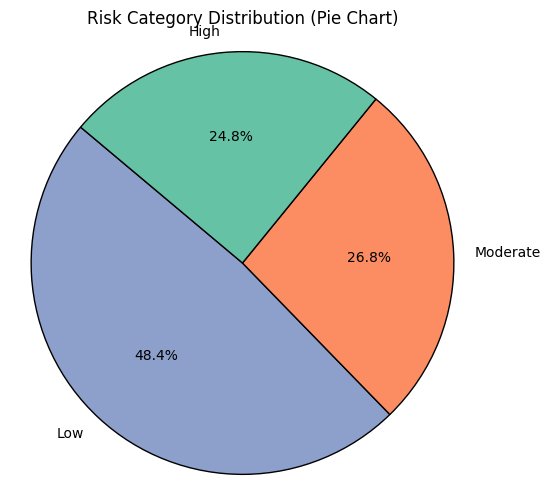

In [72]:
pie_distribution_category(data_model, col='risk_category', categories=['Low', 'Moderate', 'High'])

### 3.2.  Train Model


The random forest algorithm is a particular implementation of bagging used often for imbalanced data. Random forests create individual decision trees using a random subset of the relevant data, introducing mutliple “copies” of the data in quesiton, and combine their output in a way that is effective at preventing overfitting and improving the overall generalization of the model.

* Deals with multiclass problems
* Deals with imbalanced data: It reweights underrepresented classes automatically
* Random Forest provides feature importance scores, so you can easily identify the most impacted features for predicting risk_category

##### 3.2.1. **Train Model**

In [73]:
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_param_dist = {
    'n_estimators': randint(200, 1100),
    'max_depth': randint(10, 50), 
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 20),      
    'max_features': ['sqrt', 'log2', None]
}

rf_best_model = train_with_random_search(
    estimator=rf_clf,
    param_dist=rf_param_dist,
    X_train=X_train,
    y_train=y_train,
    model_name='rf_vanilla',
    n_iter=40,
    scoring='f1_macro',
    cv=5,
    sample_weighting=False,
    random_state=40,
    save_model=True,
    verbose=1,
    n_jobs=-1
)

Starting RandomizedSearchCV for rf_vanilla...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters for rf_vanilla: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 405}
Model saved to: best_model_rf_vanilla.joblib


##### 3.2.2. **Model Evaluation**

Accuracy: 0.5873917228103946
Macro F1 Score: 0.5616134407195378
Classification Report:
               precision    recall  f1-score   support

        High       0.65      0.51      0.57      2573
         Low       0.70      0.70      0.70      5028
    Moderate       0.38      0.45      0.41      2789

    accuracy                           0.59     10390
   macro avg       0.58      0.55      0.56     10390
weighted avg       0.60      0.59      0.59     10390



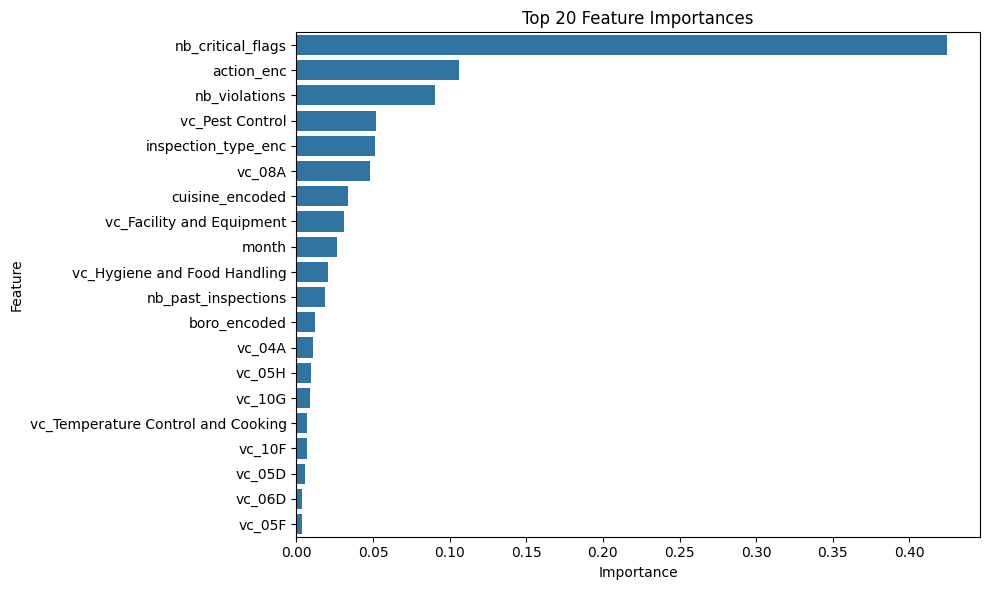

In [75]:
best_model = joblib.load("best_model_rf_vanilla.joblib")
y_pred = best_model.predict(X_test)
zip_target_enc = dict(zip(risk_enc.inverse_transform(list(set(y_pred))), list(set(y_pred))))
target_names = list(zip_target_enc.keys())


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

features_impt = plot_feature_importance(best_model, X_train, top_n=20)

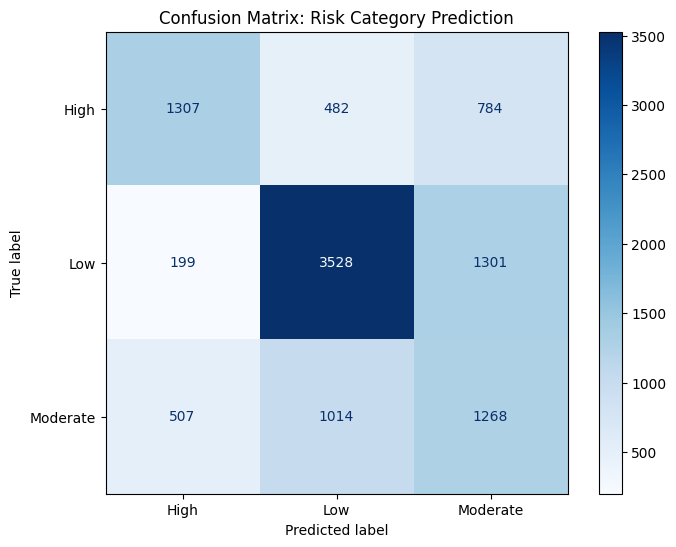

In [76]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix: Risk Category Prediction')
plt.show()

**Conclusions:**


**Accuracy:** With an accuracy of ~59% this means the model correctly predicted the risk level 59 out of every 100 cases. It's better than random guessing, it shows room for improvment.

Lets dive in **Precision, Recall and macro F1** score that shows deaply information into how the model handles each class:

_For High Risk:_
- precision: when the model says high risk it's right 65% of the time.
- recall: It's low, finds 51% half of all the actually high risk cases.
- f1 score: The balance between precision and recall is moderate.
- cm: Many high risk inspections are mistaken by moderate and low classes that leads to a lower recall. While this still reflects a weakness, mistaking high for moderate is less severe than mistaking it for low, since moderate cases may still trigger some follow up, whereas low risk classifications might lead to no action at all.

* bigger problem is the false negatives (199 + 507): This is a big problem. If a high risk restaurant is seen as low (199) or moderate (490), more severe for the lower cases, it may not get inspected soon, and serious health issues could go unnoticed. This puts public health at risk.

_For Moderate Risk:_
- precision: 38% most predictions labeled Moderate are wrong
- recall: 45% less than half of actual moderate risk inspections are detected
- f1 score: The model struggles with this class.

-> Its the weakest one with low precision and recall. It has difficulty to distinguish from the remaining classes. Mayve is ambiguous and underrepresented class.


_For Low Risk:_
- precision: 70% most predictions labeled Low are correct
- recall: 70% model identifies well the actual low risk cases
- f1 score: 70% The model has the best performance

The best performance one, for recall and precision identifies low inspections, since is the majority class, so for the remaining ones this can have impact.


Next steps to improve model:

* Get other features relevant for the model
* Select better the features, join some of them?
* Do a two label problem like High and Low (joining High and Moderate in the same class)
* Use other imbalance method
* Fetch more data

### 4.  Analysis of high risk for location and 

* map high-risk by borough.

In [159]:
borough = "Manhattan"
time_period = "January to March 2025"


prompt = f"""You are the NYC Health Department issuing a public alert based on recent inspection data {data_transformed}.
Summary of recent inspection data: From {time_period}, {borough} restaurants can show a  % increase that needs
to be calculated based on the previous inspectiond data. calculate the increase.
Draft a clear and professional alert message informing the public and restaurant owners
about this increase, its significance, and recommended actions. do not make it long and put in html format
"""

data = {
        "model": "mistral-medium",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.5
    }

response = requests.post(MISTRAL_API_ENDPOINT, headers=HEADERS, json=data)
content = response.json()["choices"][0]["message"]["content"].strip()


In [160]:
display(HTML(content))